In [ ]:
import os
import json
import pickle

import random
import numpy as np
import pandas as pd

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output  

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision

from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

Using device: cuda


# Data loader for COCO format

In [6]:
class CuneiformDataset(Dataset):
    def __init__(self, image_dir, annotation_path, transforms=None):
        self.coco = COCO(annotation_path)
        self.image_dir = image_dir
        self.ids = list(self.coco.imgs.keys())
        self.transforms = transforms or transforms.ToTensor()

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)
        path = self.coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(os.path.join(self.image_dir, path)).convert("RGB")

        boxes = []
        labels = []

        for ann in annotations:
            xmin, ymin, w, h = ann['bbox']
            boxes.append([xmin, ymin, xmin + w, ymin + h])
            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([img_id])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)


# Load datasets

In [ ]:
train_dataset = CuneiformDataset(
    image_dir="./images/train",
    annotation_path="./train_with_size_fixed.json",
    transforms=ToTensor()
)

test_dataset = CuneiformDataset(
    image_dir="./images/test",
    annotation_path="./test_with_size_fixed.json",
    transforms=ToTensor()
)
# 2 images loaded per batch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


# Initialize model with pre-trained weights

In [ ]:
# 5 anchor sizes found from average height, width, aspect ratios of the 30 signs

sizes = [45, 87, 60, 70, 148]
aspect_ratios=[1.07, 0.62, 0.67, 1.19,0.72]

anchor_sizes = tuple((s,) for s in sizes) 
anchor_aspect_ratios = tuple((ar,) for ar in aspect_ratios)

anchor = AnchorGenerator(
    sizes=anchor_sizes,
    aspect_ratios=anchor_aspect_ratios
)

torchvision.models.detection.anchor_utils.AnchorGenerator

In [ ]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes, rpn_anchor_generator=anchor)
    return model

# +1 is for background
num_classes = len(train_dataset.coco.getCatIds()) + 1  
model = get_model(num_classes)

# Model Training

In [ ]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
# learning rate = 0.0003, 25*(2/16)*0.001
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

num_epochs = 50
print("model:", next(model.parameters()).device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

    # evaluate on test set, calculate test loss
    model.train()
    val_loss = 0
    with torch.no_grad():
        for images, targets in test_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}")

    # save model after 10 epochs
    if (epoch + 1) % 10 == 0:
        save_path = f"./output/model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), save_path)
        print(f"Saved model at: {save_path}")
    
    # loss plot updated every epoch
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation (test set) Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Save final model

In [ ]:
model_path = "./output/fasterrcnn_cuneiform_finalepoch.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

# Save the label mappings from actual to coco enumerating ids

In [ ]:
with open("./train_with_size_fixed.json") as f:
    coco_data = json.load(f)

label_map = {cat['id']: cat['name'] for cat in coco_data['categories']}
label_map[0] = "background" 


In [ ]:
label_map_path = "./output/label_map.pkl"
with open(label_map_path, 'wb') as f:
    pickle.dump(label_map, f)

print(f"Label map saved to: {label_map_path}")

# Load Saved Model

In [ ]:
with open("./output/label_map.pkl", "rb") as f:
    label_map = pickle.load(f)

print(label_map)

{1: '1', 2: '10', 3: '24', 4: '71', 5: '89', 6: '110', 7: '112', 8: '142', 9: '248', 10: '252', 11: '380', 12: '464', 13: '490', 14: '514', 15: '552', 16: '566', 17: '578', 18: '580', 19: '596', 20: '599', 21: '661', 22: '724', 23: '736', 24: '737', 25: '748', 26: '754', 27: '812', 28: '839', 29: '859', 30: '869', 0: 'background'}


In [ ]:
num_classes = len(label_map)

model = fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# load saved weights
model.load_state_dict(torch.load("./output/model_epoch_50.pth"))
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s] 


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

# Visualize prediction on Test Image

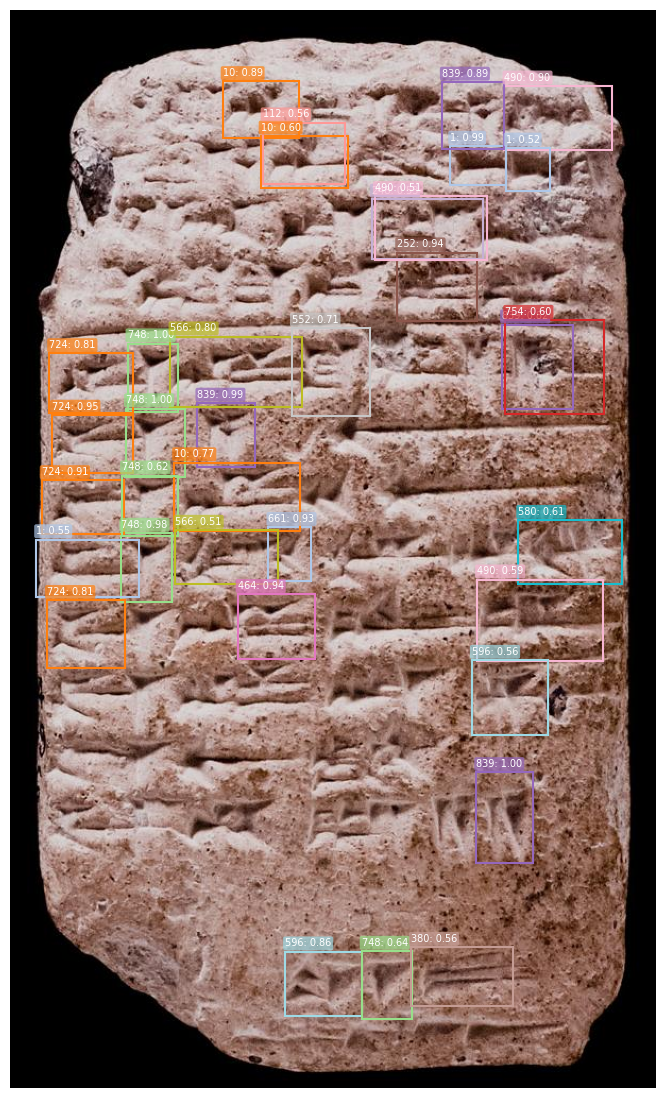

In [ ]:


# assign colors for the 30 classes (20 max)
def generate_class_colors(label_map):
    cmap = plt.get_cmap("tab20") 
    color_dict = {}
    for i, label_id in enumerate(sorted(label_map.keys())):
        if label_id == 0:
            continue 
        color_dict[label_id] = cmap(i % 20)
    return color_dict
    
class_colors = generate_class_colors(label_map)

# put model in eval mode from training mode
model.eval()

def visualize_prediction(img, output, label_map, threshold=0.5):
    img = np.array(img)
    boxes = output['boxes'].cpu().detach().numpy()
    scores = output['scores'].cpu().detach().numpy()
    labels = output['labels'].cpu().detach().numpy()

    fig, ax = plt.subplots(figsize=(10, 14))

    for box, score, label in zip(boxes, scores, labels):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box
            class_name = label_map.get(label, f"Class {label}")
            color = class_colors.get(label, 'red')

            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     linewidth=1.5, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin - 5, f"{class_name}: {score:.2f}",
                    fontsize=7, color='white',
                    bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

    ax.imshow(img)
    ax.axis('off')
    plt.show()
    
# change image number from 0 to 22 (23 test samples)
img_num = 5
img, _ = test_dataset[img_num]
with torch.no_grad():
    prediction = model([img.to(device)])

visualize_prediction(F.to_pil_image(img), prediction[0], label_map)

# Calculate the predictions & dump into a json file

In [ ]:
results = []

for img, target in tqdm(test_dataset):
    image_id = int(target['image_id'].item())
    with torch.no_grad():
        prediction = model([img.to(device)])[0]

    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        results.append({
            "image_id": int(image_id),
            "category_id": int(label),
            "bbox": [float(x_min), float(y_min), float(width), float(height)],
            "score": float(score)
        })



with open("./output/predictions.json", "w") as f:
    json.dump(results, f)

100%|██████████| 23/23 [00:02<00:00,  7.68it/s]


# Per class AP/ mAP Evaluation

In [ ]:
# load ground and predicted values
coco_gt = COCO("./test_with_size_fixed.json")
coco_dt = coco_gt.loadRes("./output/predictions.json")

coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')

coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.148
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

mAP is 0.068

AP for 0.5 IoU coverage is 0.123

In [ ]:
cats = coco_gt.loadCats(coco_gt.getCatIds())
cat_id_to_name = {cat['id']: cat['name'] for cat in cats}

per_class_ap = {}

for idx, cat in enumerate(coco_gt.getCatIds()):
    precision = coco_eval.eval['precision'][:, :, idx, 0, 2]  
    ap = np.mean(precision[precision > -1])  
    per_class_ap[cat_id_to_name[cat]] = ap if not np.isnan(ap) else 0.0

In [ ]:
print("Per-Class Average Precision (AP):\n")
for class_name, ap in per_class_ap.items():
    print(f"{class_name:<25} AP = {ap:.4f}")

Per-Class Average Precision (AP):

1                         AP = 0.0323
10                        AP = 0.0718
24                        AP = 0.0053
71                        AP = 0.0386
89                        AP = 0.0827
110                       AP = 0.0295
112                       AP = 0.0337
142                       AP = 0.0028
248                       AP = 0.0898
252                       AP = 0.1923
380                       AP = 0.0514
464                       AP = 0.0416
490                       AP = 0.0694
514                       AP = 0.0269
552                       AP = 0.0123
566                       AP = 0.0273
578                       AP = 0.1421
580                       AP = 0.0026
596                       AP = 0.0953
599                       AP = 0.0000
661                       AP = 0.0357
724                       AP = 0.1281
736                       AP = 0.0287
737                       AP = 0.0323
748                       AP = 0.1669
754            

# Confusion Matrix for specific labels (use coco class ids)

100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


<Figure size 600x500 with 0 Axes>

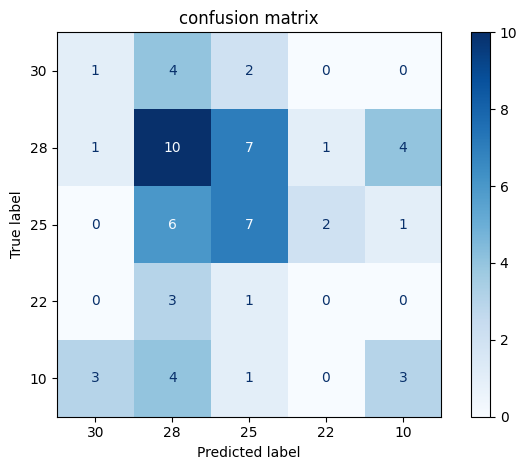

In [ ]:

# original cuneiform character mzl_label codes: 869, 839, 748, 724, 252
# coco mapped codes below
target_model_labels = [30, 28, 25, 22, 10]

y_true = []
y_pred = []

model.eval()
threshold = 0.5

for idx in tqdm(range(len(test_dataset))):
    img, target = test_dataset[idx]
    
    # skip images with empty annotations
    if target['labels'].numel() == 0:
        continue

    img_tensor = img.to(device).unsqueeze(0) 

    with torch.no_grad():
        prediction = model(img_tensor)[0]

    gt_labels = target['labels'].numpy()
    pred_labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()

    pred_labels = pred_labels[scores >= threshold]

    min_len = min(len(gt_labels), len(pred_labels))
    for i in range(min_len):
        gt = gt_labels[i]
        pred = pred_labels[i]

        if gt in target_model_labels or pred in target_model_labels:
            y_true.append(gt)
            y_pred.append(pred)

labels_to_show = target_model_labels

cm = confusion_matrix(y_true, y_pred, labels=labels_to_show)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_to_show)

plt.figure(figsize=(6, 5))
disp.plot(values_format='d')
plt.title("confusion matrix")
plt.show()